In [1]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import itertools

In [2]:
n_rolls = 5000
n_sides = 6
diceroll1 = np.random.choice(np.arange(n_sides)+1, size=n_rolls)
diceroll2 = np.random.choice(np.arange(n_sides)+1, size=n_rolls)

sum_rolls = diceroll1 + diceroll2
max_rolls = np.max(np.vstack([diceroll1,diceroll2]), axis=0)

# p(X,Y)
xy = np.zeros((n_sides*2-1, n_sides))
for s, m in zip(sum_rolls, max_rolls):
    xy[s-2, m-1] += 1
xy /= n_rolls

# xy[-2:,0:2] = 0.4
# xy = xy/np.sum(xy)

# p(X), p(Y)
x = np.sum(xy, axis=1)
y = np.sum(xy, axis=0)

In [3]:
xy

array([[0.0302, 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.0564, 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.026 , 0.0564, 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.0518, 0.056 , 0.    , 0.    ],
       [0.    , 0.    , 0.0296, 0.051 , 0.0534, 0.    ],
       [0.    , 0.    , 0.    , 0.0556, 0.0564, 0.0548],
       [0.    , 0.    , 0.    , 0.0294, 0.051 , 0.0576],
       [0.    , 0.    , 0.    , 0.    , 0.0586, 0.053 ],
       [0.    , 0.    , 0.    , 0.    , 0.0296, 0.0562],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.0588],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.0282]])

In [4]:
x

array([0.0302, 0.0564, 0.0824, 0.1078, 0.134 , 0.1668, 0.138 , 0.1116,
       0.0858, 0.0588, 0.0282])

In [5]:
y

array([0.0302, 0.0824, 0.1378, 0.192 , 0.249 , 0.3086])

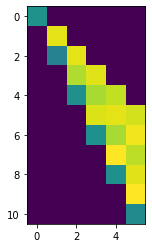

In [6]:
plt.imshow(xy)

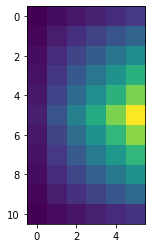

In [7]:
xyind = x[None].T @ y[None]
plt.imshow(xyind)
# print(torch.var(M))

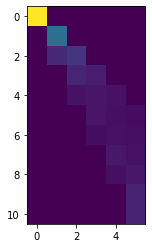

In [8]:
plt.imshow(xy/xyind)
# print(torch.var(M))

## Experiments (normalized across minibatch)

In [9]:
def run_expr(n_batch, iters):
    '''
    model pxy directly
    '''
    torch.manual_seed(42)
    
    M = torch.randn((x.shape[0],y.shape[0]), requires_grad = True)
    print(M[0, :5])
    
    optimizer = torch.optim.SGD([M],1, 0.99)
    Mbar = M.data
    
    history = {'loss':[]}
    
    for iteration in tqdm(range(1,iters)):

        samples = [np.random.choice(range(xy.reshape(-1).shape[0]), p=xy.reshape(-1)) for i in range(n_batch)]
        samples = np.array([(yi//(y.shape[0]), yi%(y.shape[0])) for yi in samples])

        optimizer.zero_grad()

        F = torch.exp(M)

        loss = 0
        for i in range(n_batch):
            lossi = F[samples[i,0],samples[i,1]]/torch.sum(F[:,:])
            loss = loss + torch.log(lossi)
        loss = -1*loss/n_batch
        loss.backward()
        optimizer.step()
        history['loss'].append(loss.item())
        Mbar = (1-1/iteration)*Mbar + (1/iteration)*M.data

        if iteration % 100 == 0:
            print(torch.var(M))
            plt.imshow(Mbar.detach().cpu().numpy())
            plt.savefig(f"dicerolls6_training_results/Mbar_joint_{n_batch}_{iteration}.png")

    np.save(f'dicerolls6_training_results/Mbar_joint_{n_batch}_{iteration}.npy', Mbar.detach().cpu().numpy())
    np.save(f'dicerolls6_training_results/M_joint_{n_batch}_{iteration}.npy', M.detach().cpu().numpy())
    np.save(f'dicerolls6_training_results/training_loss_joint_{n_batch}_{iteration}.npy', np.array(history['loss']))
    return M, Mbar, history

  0%|          | 3/4999 [00:00<03:28, 23.91it/s]

tensor([ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784], grad_fn=<SliceBackward>)


  2%|▏         | 103/4999 [00:03<02:58, 27.50it/s]

tensor(177.0855, grad_fn=<VarBackward0>)


  4%|▍         | 204/4999 [00:06<02:48, 28.54it/s]

tensor(349.0634, grad_fn=<VarBackward0>)


  6%|▌         | 304/4999 [00:10<02:57, 26.50it/s]

tensor(426.4250, grad_fn=<VarBackward0>)


  8%|▊         | 404/4999 [00:13<02:53, 26.55it/s]

tensor(456.7366, grad_fn=<VarBackward0>)


 10%|█         | 503/4999 [00:17<02:41, 27.78it/s]

tensor(468.0218, grad_fn=<VarBackward0>)


 12%|█▏        | 604/4999 [00:20<02:39, 27.57it/s]

tensor(472.1959, grad_fn=<VarBackward0>)


 14%|█▍        | 702/4999 [00:24<02:40, 26.82it/s]

tensor(473.7387, grad_fn=<VarBackward0>)


 16%|█▌        | 801/4999 [00:27<02:37, 26.71it/s]

tensor(474.3359, grad_fn=<VarBackward0>)


 18%|█▊        | 901/4999 [00:30<02:29, 27.40it/s]

tensor(474.5664, grad_fn=<VarBackward0>)


 20%|██        | 1002/4999 [00:34<02:32, 26.25it/s]

tensor(474.6179, grad_fn=<VarBackward0>)


 22%|██▏       | 1103/4999 [00:37<02:19, 27.85it/s]

tensor(474.6163, grad_fn=<VarBackward0>)


 24%|██▍       | 1203/4999 [00:41<02:23, 26.42it/s]

tensor(474.6302, grad_fn=<VarBackward0>)


 26%|██▌       | 1302/4999 [00:44<02:25, 25.45it/s]

tensor(474.6188, grad_fn=<VarBackward0>)


 28%|██▊       | 1404/4999 [00:48<02:15, 26.60it/s]

tensor(474.6688, grad_fn=<VarBackward0>)


 30%|███       | 1504/4999 [00:51<02:13, 26.18it/s]

tensor(474.6389, grad_fn=<VarBackward0>)


 32%|███▏      | 1603/4999 [00:55<02:08, 26.39it/s]

tensor(474.6492, grad_fn=<VarBackward0>)


 34%|███▍      | 1702/4999 [00:58<02:11, 25.17it/s]

tensor(474.6281, grad_fn=<VarBackward0>)


 36%|███▌      | 1803/4999 [01:01<02:03, 25.92it/s]

tensor(474.6319, grad_fn=<VarBackward0>)


 38%|███▊      | 1902/4999 [01:05<02:04, 24.84it/s]

tensor(474.6254, grad_fn=<VarBackward0>)


 40%|████      | 2003/4999 [01:08<01:54, 26.09it/s]

tensor(474.6600, grad_fn=<VarBackward0>)


 42%|████▏     | 2102/4999 [01:12<01:51, 25.95it/s]

tensor(474.6549, grad_fn=<VarBackward0>)


 44%|████▍     | 2201/4999 [01:15<01:53, 24.57it/s]

tensor(474.6357, grad_fn=<VarBackward0>)


 46%|████▌     | 2301/4999 [01:18<01:50, 24.39it/s]

tensor(474.6419, grad_fn=<VarBackward0>)


 48%|████▊     | 2402/4999 [01:22<01:41, 25.57it/s]

tensor(474.6529, grad_fn=<VarBackward0>)


 50%|█████     | 2503/4999 [01:25<01:33, 26.57it/s]

tensor(474.6478, grad_fn=<VarBackward0>)


 52%|█████▏    | 2601/4999 [01:29<01:39, 23.99it/s]

tensor(474.6491, grad_fn=<VarBackward0>)


 54%|█████▍    | 2703/4999 [01:32<01:27, 26.31it/s]

tensor(474.6322, grad_fn=<VarBackward0>)


 56%|█████▌    | 2803/4999 [01:36<01:26, 25.29it/s]

tensor(474.6564, grad_fn=<VarBackward0>)


 58%|█████▊    | 2903/4999 [01:39<01:20, 26.18it/s]

tensor(474.6470, grad_fn=<VarBackward0>)


 60%|██████    | 3003/4999 [01:42<01:20, 24.73it/s]

tensor(474.6250, grad_fn=<VarBackward0>)


 62%|██████▏   | 3102/4999 [01:46<01:22, 23.10it/s]

tensor(474.6332, grad_fn=<VarBackward0>)


 64%|██████▍   | 3201/4999 [01:49<01:18, 22.90it/s]

tensor(474.6426, grad_fn=<VarBackward0>)


 66%|██████▌   | 3300/4999 [01:53<01:14, 22.87it/s]

tensor(474.6684, grad_fn=<VarBackward0>)


 68%|██████▊   | 3400/4999 [01:56<01:10, 22.79it/s]

tensor(474.6218, grad_fn=<VarBackward0>)


 70%|███████   | 3501/4999 [02:00<01:05, 22.72it/s]

tensor(474.6556, grad_fn=<VarBackward0>)


 72%|███████▏  | 3602/4999 [02:03<01:01, 22.71it/s]

tensor(474.6353, grad_fn=<VarBackward0>)


 74%|███████▍  | 3701/4999 [02:07<00:57, 22.58it/s]

tensor(474.6467, grad_fn=<VarBackward0>)


 76%|███████▌  | 3802/4999 [02:10<00:53, 22.42it/s]

tensor(474.6496, grad_fn=<VarBackward0>)


 78%|███████▊  | 3900/4999 [02:14<00:49, 22.35it/s]

tensor(474.6483, grad_fn=<VarBackward0>)


 80%|████████  | 4000/4999 [02:17<00:45, 22.20it/s]

tensor(474.6467, grad_fn=<VarBackward0>)


 82%|████████▏ | 4102/4999 [02:21<00:41, 21.81it/s]

tensor(474.6219, grad_fn=<VarBackward0>)


 84%|████████▍ | 4200/4999 [02:24<00:33, 23.59it/s]

tensor(474.6202, grad_fn=<VarBackward0>)


 86%|████████▌ | 4302/4999 [02:27<00:32, 21.32it/s]

tensor(474.6350, grad_fn=<VarBackward0>)


 88%|████████▊ | 4400/4999 [02:31<00:27, 21.72it/s]

tensor(474.6172, grad_fn=<VarBackward0>)


 90%|█████████ | 4500/4999 [02:34<00:23, 21.03it/s]

tensor(474.6193, grad_fn=<VarBackward0>)


 92%|█████████▏| 4602/4999 [02:38<00:18, 20.92it/s]

tensor(474.6311, grad_fn=<VarBackward0>)


 94%|█████████▍| 4702/4999 [02:42<00:14, 21.21it/s]

tensor(474.6472, grad_fn=<VarBackward0>)


 96%|█████████▌| 4801/4999 [02:45<00:09, 20.53it/s]

tensor(474.6159, grad_fn=<VarBackward0>)


 98%|█████████▊| 4899/4999 [02:48<00:03, 29.78it/s]

tensor(474.6360, grad_fn=<VarBackward0>)


100%|██████████| 4999/4999 [02:52<00:00, 29.00it/s]


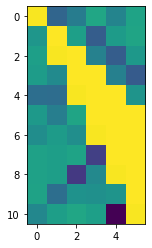

In [10]:
# model pxy directly
M, Mbar, history = run_expr(n_batch=500, iters=5000)

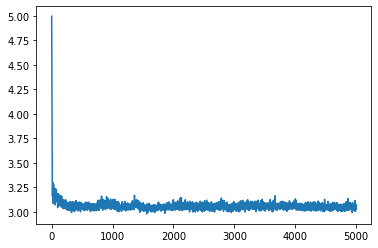

In [11]:
plt.plot(history['loss'])

In [12]:
Mbar_joint = torch.from_numpy(np.load(f'dicerolls6_training_results/Mbar_joint_{500}_{4999}.npy'))
M_joint = torch.from_numpy(np.load(f'dicerolls6_training_results/M_joint_{500}_{4999}.npy'))

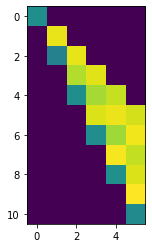

In [13]:
plt.imshow(torch.exp(Mbar_joint))

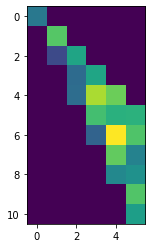

In [14]:
plt.imshow(torch.exp(M_joint))

In [15]:
# Compare Mbar with xy
F_joint = torch.exp(Mbar_joint)
F_joint_normalized = F_joint/torch.sum(F_joint)
log_F_joint_normalized = torch.log(F_joint_normalized)

F.kl_div(log_F_joint_normalized, torch.from_numpy(xy))

/home/user/miniconda/lib/python3.8/site-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


tensor(5.5292e-07, dtype=torch.float64)

In [16]:
def run_expr_pseudo(n_batch, iters):
    '''
    model x|y and y|x
    '''
    torch.manual_seed(42)
    
    M = torch.randn((x.shape[0],y.shape[0]), requires_grad = True)
    print(M[0, :5])
    
    optimizer = torch.optim.SGD([M],1, 0.99)
    Mbar = M.data
    
    history = {'loss':[]}
    
    for iteration in tqdm(range(1,iters)):

        samples = [np.random.choice(range(xy.reshape(-1).shape[0]), p=xy.reshape(-1)) for i in range(n_batch)]
        samples = np.array([(yi//(y.shape[0]), yi%(y.shape[0])) for yi in samples])

        optimizer.zero_grad()

        F = torch.exp(M)

        loss = 0
        for i in range(n_batch):
            lossi_x = F[samples[i,0],samples[i,1]]/torch.sum(F[samples[i,0], range(xy.shape[1])])
            lossi_y = F[samples[i,0],samples[i,1]]/torch.sum(F[range(xy.shape[0]), samples[i,1]])

            loss = loss + ((torch.log(lossi_x) + torch.log(lossi_y)) * 0.5)
            
        loss = -1*loss/n_batch
        loss.backward()
        optimizer.step()
        history['loss'].append(loss.item())
        Mbar = (1-1/iteration)*Mbar + (1/iteration)*M.data

        if iteration % 100 == 0:
            print(torch.var(M))
            plt.imshow(Mbar.detach().cpu().numpy())
            plt.savefig(f"dicerolls6_training_results/Mbar_pseudo_{n_batch}_{iteration}.png")

    np.save(f'dicerolls6_training_results/Mbar_pseudo_{n_batch}_{iteration}.npy', Mbar.detach().cpu().numpy())
    np.save(f'dicerolls6_training_results/M_pseudo_{n_batch}_{iteration}.npy', M.detach().cpu().numpy())
    np.save(f'dicerolls6_training_results/training_loss_pseudo_{n_batch}_{iteration}.npy', np.array(history['loss']))
    return M, Mbar, history

  0%|          | 2/4999 [00:00<06:22, 13.06it/s]

tensor([ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784], grad_fn=<SliceBackward>)


  2%|▏         | 102/4999 [00:07<06:27, 12.62it/s]

tensor(166.5578, grad_fn=<VarBackward0>)


  4%|▍         | 202/4999 [00:15<06:13, 12.85it/s]

tensor(329.0647, grad_fn=<VarBackward0>)


  6%|▌         | 302/4999 [00:22<05:52, 13.32it/s]

tensor(402.2189, grad_fn=<VarBackward0>)


  8%|▊         | 402/4999 [00:29<05:47, 13.23it/s]

tensor(430.8928, grad_fn=<VarBackward0>)


 10%|█         | 502/4999 [00:37<05:38, 13.27it/s]

tensor(441.5714, grad_fn=<VarBackward0>)


 12%|█▏        | 602/4999 [00:44<05:37, 13.04it/s]

tensor(445.5516, grad_fn=<VarBackward0>)


 14%|█▍        | 702/4999 [00:52<05:26, 13.15it/s]

tensor(446.9826, grad_fn=<VarBackward0>)


 16%|█▌        | 802/4999 [00:59<05:18, 13.19it/s]

tensor(447.5289, grad_fn=<VarBackward0>)


 18%|█▊        | 902/4999 [01:06<05:17, 12.89it/s]

tensor(447.7343, grad_fn=<VarBackward0>)


 20%|██        | 1002/4999 [01:14<05:24, 12.30it/s]

tensor(447.7920, grad_fn=<VarBackward0>)


 22%|██▏       | 1102/4999 [01:21<05:01, 12.94it/s]

tensor(447.8310, grad_fn=<VarBackward0>)


 24%|██▍       | 1202/4999 [01:28<04:58, 12.72it/s]

tensor(447.8484, grad_fn=<VarBackward0>)


 26%|██▌       | 1300/4999 [01:35<05:00, 12.29it/s]

tensor(447.8332, grad_fn=<VarBackward0>)


 28%|██▊       | 1400/4999 [01:43<04:51, 12.36it/s]

tensor(447.8477, grad_fn=<VarBackward0>)


 30%|███       | 1500/4999 [01:50<04:42, 12.38it/s]

tensor(447.8490, grad_fn=<VarBackward0>)


 32%|███▏      | 1600/4999 [01:58<04:44, 11.94it/s]

tensor(447.8247, grad_fn=<VarBackward0>)


 34%|███▍      | 1700/4999 [02:05<04:30, 12.17it/s]

tensor(447.8322, grad_fn=<VarBackward0>)


 36%|███▌      | 1800/4999 [02:13<04:29, 11.85it/s]

tensor(447.8219, grad_fn=<VarBackward0>)


 38%|███▊      | 1900/4999 [02:21<04:21, 11.87it/s]

tensor(447.8314, grad_fn=<VarBackward0>)


 40%|████      | 2000/4999 [02:28<04:20, 11.51it/s]

tensor(447.8172, grad_fn=<VarBackward0>)


 42%|████▏     | 2100/4999 [02:35<04:01, 11.99it/s]

tensor(447.8445, grad_fn=<VarBackward0>)


 44%|████▍     | 2200/4999 [02:43<04:02, 11.54it/s]

tensor(447.8442, grad_fn=<VarBackward0>)


 46%|████▌     | 2300/4999 [02:50<03:45, 11.97it/s]

tensor(447.8515, grad_fn=<VarBackward0>)


 48%|████▊     | 2400/4999 [02:58<03:43, 11.63it/s]

tensor(447.8513, grad_fn=<VarBackward0>)


 50%|█████     | 2500/4999 [03:05<03:33, 11.72it/s]

tensor(447.8546, grad_fn=<VarBackward0>)


 52%|█████▏    | 2600/4999 [03:13<03:33, 11.22it/s]

tensor(447.8405, grad_fn=<VarBackward0>)


 54%|█████▍    | 2700/4999 [03:20<03:22, 11.36it/s]

tensor(447.8494, grad_fn=<VarBackward0>)


 56%|█████▌    | 2800/4999 [03:28<03:10, 11.56it/s]

tensor(447.8577, grad_fn=<VarBackward0>)


 58%|█████▊    | 2900/4999 [03:35<03:02, 11.53it/s]

tensor(447.8320, grad_fn=<VarBackward0>)


 60%|██████    | 3000/4999 [03:43<02:53, 11.53it/s]

tensor(447.8320, grad_fn=<VarBackward0>)


 62%|██████▏   | 3100/4999 [03:50<02:43, 11.59it/s]

tensor(447.8393, grad_fn=<VarBackward0>)


 64%|██████▍   | 3200/4999 [03:58<02:37, 11.43it/s]

tensor(447.8526, grad_fn=<VarBackward0>)


 66%|██████▌   | 3300/4999 [04:05<02:27, 11.50it/s]

tensor(447.8675, grad_fn=<VarBackward0>)


 68%|██████▊   | 3400/4999 [04:12<02:21, 11.34it/s]

tensor(447.8517, grad_fn=<VarBackward0>)


 70%|███████   | 3500/4999 [04:20<02:13, 11.19it/s]

tensor(447.8372, grad_fn=<VarBackward0>)


 72%|███████▏  | 3600/4999 [04:27<02:04, 11.26it/s]

tensor(447.8470, grad_fn=<VarBackward0>)


 74%|███████▍  | 3700/4999 [04:34<01:55, 11.26it/s]

tensor(447.8340, grad_fn=<VarBackward0>)


 76%|███████▌  | 3800/4999 [04:42<01:48, 11.07it/s]

tensor(447.8228, grad_fn=<VarBackward0>)


 78%|███████▊  | 3900/4999 [04:49<01:41, 10.82it/s]

tensor(447.8204, grad_fn=<VarBackward0>)


 80%|████████  | 4000/4999 [04:57<01:29, 11.13it/s]

tensor(447.8289, grad_fn=<VarBackward0>)


 82%|████████▏ | 4100/4999 [05:04<01:22, 10.96it/s]

tensor(447.8153, grad_fn=<VarBackward0>)


 84%|████████▍ | 4200/4999 [05:12<01:14, 10.70it/s]

tensor(447.8346, grad_fn=<VarBackward0>)


 86%|████████▌ | 4300/4999 [05:19<01:06, 10.48it/s]

tensor(447.8274, grad_fn=<VarBackward0>)


 88%|████████▊ | 4400/4999 [05:27<00:55, 10.75it/s]

tensor(447.8482, grad_fn=<VarBackward0>)


 90%|█████████ | 4500/4999 [05:35<00:45, 10.85it/s]

tensor(447.8644, grad_fn=<VarBackward0>)


 92%|█████████▏| 4600/4999 [05:42<00:37, 10.66it/s]

tensor(447.8477, grad_fn=<VarBackward0>)


 94%|█████████▍| 4700/4999 [05:50<00:27, 10.86it/s]

tensor(447.8379, grad_fn=<VarBackward0>)


 96%|█████████▌| 4800/4999 [05:57<00:18, 10.57it/s]

tensor(447.8272, grad_fn=<VarBackward0>)


 98%|█████████▊| 4900/4999 [06:05<00:09, 10.55it/s]

tensor(447.8459, grad_fn=<VarBackward0>)


100%|██████████| 4999/4999 [06:12<00:00, 13.43it/s]


(tensor([[ 21.3635, -14.5613, -12.5911,  -2.9938, -11.9526,  -4.2921],
         [ -6.3420,  28.7446,  -5.9981, -27.7186,  -8.0965,  -5.0462],
         [ -4.3674,  27.4465,  28.6766, -16.7039, -31.3158, -11.0004],
         [ -4.4067, -11.0352,  27.9554,  28.9276, -17.6824, -33.4795],
         [-15.4035, -19.7478,  28.1705,  27.9540,  28.3273, -12.0107],
         [ -8.1683, -20.3717,  -5.3323,  28.5084,  28.4643,  28.6544],
         [-13.5503,  -9.4491, -16.8088,  28.1007,  28.7033,  28.5614],
         [ -5.0433,  -7.1416,  -5.3428, -42.6185,  28.4304,  28.3027],
         [ -3.6064,  -5.2560, -38.1651, -13.0013,  27.9318,  28.9143],
         [ -3.0687, -17.2010,  -9.5532,  -9.7029,  -9.7140,  28.6786],
         [ -6.5794,  -4.4061,  -3.2868,  -4.7996, -44.6371,  28.0115]],
        requires_grad=True),
 tensor([[ 20.9533, -14.2246, -12.3090,  -2.9748, -11.6883,  -4.2275],
         [ -6.2090,  27.9843,  -5.8875, -27.1126,  -7.9345,  -4.9694],
         [ -4.2905,  27.1829,  27.9831, -16.340

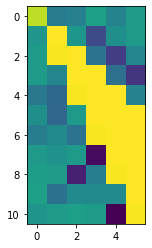

In [17]:
run_expr_pseudo(n_batch=500, iters=5000)

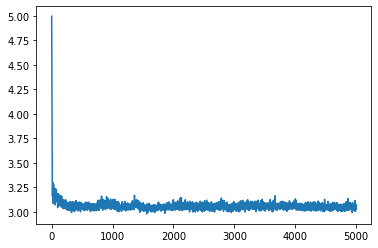

In [18]:
plt.plot(history['loss'])

In [30]:
Mbar_pseudo = torch.from_numpy(np.load(f'dicerolls6_training_results/Mbar_pseudo_{500}_{4999}.npy'))
M_pseudo = torch.from_numpy(np.load(f'dicerolls6_training_results/M_pseudo_{500}_{4999}.npy'))

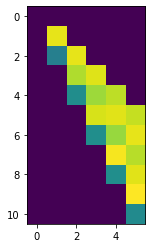

In [31]:
plt.imshow(torch.exp(Mbar_pseudo))

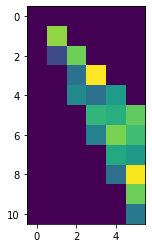

In [32]:
plt.imshow(torch.exp(M_pseudo))

In [33]:
# Compare Mbar with xy
F_pseudo = torch.exp(Mbar_pseudo)
F_pseudo_normalized = F_pseudo/torch.sum(F_pseudo)
log_F_pseudo_normalized = torch.log(F_pseudo_normalized)

F.kl_div(log_F_pseudo_normalized, torch.from_numpy(xy))

tensor(0.0025, dtype=torch.float64)

In [23]:
def run_expr_infoNCE(n_batch, iters):
    '''
    infoNCE
    '''
    torch.manual_seed(42)
    
    M = torch.randn((x.shape[0],y.shape[0]), requires_grad = True)
    print(M[0, :5])
    
    optimizer = torch.optim.SGD([M],1, 0.99)
    Mbar = M.data
    
    history = {'loss':[]}
    
    for iteration in tqdm(range(1,iters)):

        samples = [np.random.choice(range(xy.reshape(-1).shape[0]), p=xy.reshape(-1)) for i in range(n_batch)]
        samples = np.array([(yi//(y.shape[0]), yi%(y.shape[0])) for yi in samples])

        optimizer.zero_grad()

        F = torch.exp(M)

        loss = 0
        for i in range(n_batch):
            lossi_x = F[samples[i,0],samples[i,1]]/torch.sum(F[samples[i,0], samples[:,1]])
            lossi_y = F[samples[i,0],samples[i,1]]/torch.sum(F[samples[:,0], samples[i,1]])
            
            loss = loss + ((torch.log(lossi_x) + torch.log(lossi_y)) * 0.5)
        
        loss = -1*loss/n_batch
        loss.backward()
        optimizer.step()
        history['loss'].append(loss.item())
        Mbar = (1-1/iteration)*Mbar + (1/iteration)*M.data

        if iteration % 100 == 0:
            print(torch.var(M))
            plt.imshow(Mbar.detach().cpu().numpy())
            plt.savefig(f"dicerolls6_training_results/Mbar_infoNCE_{n_batch}_{iteration}.png")

    np.save(f'dicerolls6_training_results/Mbar_infoNCE_{n_batch}_{iteration}.npy', Mbar.detach().cpu().numpy())
    np.save(f'dicerolls6_training_results/M_infoNCE_{n_batch}_{iteration}.npy', M.detach().cpu().numpy())
    np.save(f'dicerolls6_training_results/training_loss_infoNCE_{n_batch}_{iteration}.npy', np.array(history['loss']))
    return M, Mbar, history

  0%|          | 2/4999 [00:00<06:35, 12.63it/s]

tensor([ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784], grad_fn=<SliceBackward>)


  2%|▏         | 102/4999 [00:07<06:41, 12.19it/s]

tensor(136.1312, grad_fn=<VarBackward0>)


  4%|▍         | 202/4999 [00:15<06:28, 12.36it/s]

tensor(269.9012, grad_fn=<VarBackward0>)


  6%|▌         | 302/4999 [00:23<06:27, 12.12it/s]

tensor(329.6020, grad_fn=<VarBackward0>)


  8%|▊         | 402/4999 [00:31<06:09, 12.46it/s]

tensor(353.1671, grad_fn=<VarBackward0>)


 10%|█         | 502/4999 [00:39<06:02, 12.41it/s]

tensor(361.9789, grad_fn=<VarBackward0>)


 12%|█▏        | 602/4999 [00:46<06:01, 12.16it/s]

tensor(365.1696, grad_fn=<VarBackward0>)


 14%|█▍        | 702/4999 [00:54<05:52, 12.21it/s]

tensor(366.4069, grad_fn=<VarBackward0>)


 16%|█▌        | 800/4999 [01:02<06:04, 11.51it/s]

tensor(366.8294, grad_fn=<VarBackward0>)


 18%|█▊        | 900/4999 [01:10<06:01, 11.34it/s]

tensor(366.9836, grad_fn=<VarBackward0>)


 20%|██        | 1000/4999 [01:18<05:41, 11.71it/s]

tensor(367.0591, grad_fn=<VarBackward0>)


 22%|██▏       | 1100/4999 [01:26<05:37, 11.56it/s]

tensor(367.0536, grad_fn=<VarBackward0>)


 24%|██▍       | 1200/4999 [01:34<05:26, 11.62it/s]

tensor(367.0705, grad_fn=<VarBackward0>)


 26%|██▌       | 1300/4999 [01:42<05:15, 11.71it/s]

tensor(367.0880, grad_fn=<VarBackward0>)


 28%|██▊       | 1400/4999 [01:50<05:05, 11.77it/s]

tensor(367.0523, grad_fn=<VarBackward0>)


 30%|███       | 1500/4999 [01:57<04:58, 11.71it/s]

tensor(367.0754, grad_fn=<VarBackward0>)


 32%|███▏      | 1600/4999 [02:05<04:51, 11.66it/s]

tensor(367.0714, grad_fn=<VarBackward0>)


 34%|███▍      | 1700/4999 [02:13<04:52, 11.27it/s]

tensor(367.0794, grad_fn=<VarBackward0>)


 36%|███▌      | 1800/4999 [02:21<04:36, 11.59it/s]

tensor(367.0571, grad_fn=<VarBackward0>)


 38%|███▊      | 1900/4999 [02:29<04:30, 11.47it/s]

tensor(367.0694, grad_fn=<VarBackward0>)


 40%|████      | 2000/4999 [02:36<04:21, 11.45it/s]

tensor(367.0874, grad_fn=<VarBackward0>)


 42%|████▏     | 2100/4999 [02:44<04:16, 11.32it/s]

tensor(367.0730, grad_fn=<VarBackward0>)


 44%|████▍     | 2200/4999 [02:52<04:24, 10.57it/s]

tensor(367.0630, grad_fn=<VarBackward0>)


 46%|████▌     | 2300/4999 [03:00<03:58, 11.29it/s]

tensor(367.0676, grad_fn=<VarBackward0>)


 48%|████▊     | 2400/4999 [03:08<03:51, 11.24it/s]

tensor(367.0732, grad_fn=<VarBackward0>)


 50%|█████     | 2500/4999 [03:16<03:42, 11.21it/s]

tensor(367.0721, grad_fn=<VarBackward0>)


 52%|█████▏    | 2600/4999 [03:24<03:37, 11.01it/s]

tensor(367.0712, grad_fn=<VarBackward0>)


 54%|█████▍    | 2700/4999 [03:32<03:30, 10.94it/s]

tensor(367.0834, grad_fn=<VarBackward0>)


 56%|█████▌    | 2800/4999 [03:40<03:23, 10.80it/s]

tensor(367.0856, grad_fn=<VarBackward0>)


 58%|█████▊    | 2900/4999 [03:48<03:14, 10.78it/s]

tensor(367.0772, grad_fn=<VarBackward0>)


 60%|██████    | 3000/4999 [03:56<03:01, 11.00it/s]

tensor(367.0797, grad_fn=<VarBackward0>)


 62%|██████▏   | 3100/4999 [04:03<02:53, 10.95it/s]

tensor(367.0725, grad_fn=<VarBackward0>)


 64%|██████▍   | 3200/4999 [04:11<02:45, 10.89it/s]

tensor(367.0741, grad_fn=<VarBackward0>)


 66%|██████▌   | 3300/4999 [04:19<02:37, 10.79it/s]

tensor(367.0906, grad_fn=<VarBackward0>)


 68%|██████▊   | 3400/4999 [04:27<02:28, 10.74it/s]

tensor(367.0761, grad_fn=<VarBackward0>)


 70%|███████   | 3500/4999 [04:35<02:18, 10.82it/s]

tensor(367.0822, grad_fn=<VarBackward0>)


 72%|███████▏  | 3600/4999 [04:43<02:11, 10.68it/s]

tensor(367.0657, grad_fn=<VarBackward0>)


 74%|███████▍  | 3700/4999 [04:51<02:05, 10.33it/s]

tensor(367.0793, grad_fn=<VarBackward0>)


 76%|███████▌  | 3800/4999 [04:59<01:54, 10.44it/s]

tensor(367.1096, grad_fn=<VarBackward0>)


 78%|███████▊  | 3900/4999 [05:07<01:45, 10.42it/s]

tensor(367.0847, grad_fn=<VarBackward0>)


 80%|████████  | 4000/4999 [05:15<01:39, 10.01it/s]

tensor(367.0683, grad_fn=<VarBackward0>)


 82%|████████▏ | 4100/4999 [05:23<01:25, 10.51it/s]

tensor(367.0844, grad_fn=<VarBackward0>)


 84%|████████▍ | 4200/4999 [05:31<01:18, 10.18it/s]

tensor(367.0850, grad_fn=<VarBackward0>)


 86%|████████▌ | 4300/4999 [05:39<01:09, 10.06it/s]

tensor(367.0694, grad_fn=<VarBackward0>)


 88%|████████▊ | 4400/4999 [05:47<00:58, 10.29it/s]

tensor(367.0667, grad_fn=<VarBackward0>)


 90%|█████████ | 4500/4999 [05:55<00:48, 10.35it/s]

tensor(367.0748, grad_fn=<VarBackward0>)


 92%|█████████▏| 4600/4999 [06:04<00:40,  9.85it/s]

tensor(367.1084, grad_fn=<VarBackward0>)


 94%|█████████▍| 4700/4999 [06:12<00:29, 10.04it/s]

tensor(367.0694, grad_fn=<VarBackward0>)


 96%|█████████▌| 4800/4999 [06:20<00:19, 10.18it/s]

tensor(367.0770, grad_fn=<VarBackward0>)


 98%|█████████▊| 4900/4999 [06:28<00:09, 10.06it/s]

tensor(367.0789, grad_fn=<VarBackward0>)


100%|██████████| 4999/4999 [06:36<00:00, 12.62it/s]


(tensor([[ 32.5365,  -7.3131,  -6.8063,  -2.6946,  -9.2777,  -3.5218],
         [ -1.9354,  25.8315,  -4.7992, -26.9565,  -9.3951,  -5.7740],
         [ -1.8992,  24.5783,  24.7097, -17.5845, -36.5741, -14.0933],
         [ -2.0325,  -8.8477,  24.7206,  24.5218, -22.5984, -39.3827],
         [ -8.5637, -20.1965,  23.9207,  23.6427,  24.2144, -19.9611],
         [ -3.7674, -19.1446,  -6.3500,  23.6223,  23.5046,  23.7898],
         [ -5.0534,  -7.8173, -18.0038,  23.3707,  23.8303,  23.4401],
         [ -2.1320,  -5.0307,  -4.8246, -42.9995,  24.1255,  23.4041],
         [ -1.7858,  -3.6847, -33.7048, -12.5767,  23.5593,  24.2109],
         [ -1.5886, -10.1314,  -6.5737,  -7.8680,  -9.4016,  24.5312],
         [ -0.6391,  -1.6580,  -2.5388,  -2.3950, -29.4041,  24.4924]],
        requires_grad=True),
 tensor([[ 31.8860,  -7.1265,  -6.6439,  -2.6819,  -9.0677,  -3.4726],
         [ -1.8950,  25.3317,  -4.7137, -26.3619,  -9.2050,  -5.6809],
         [ -1.8742,  24.1515,  24.4290, -17.201

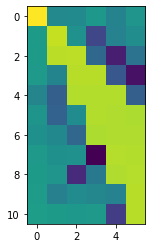

In [24]:
run_expr_infoNCE(n_batch=500, iters=5000)

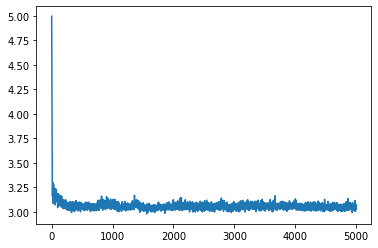

In [25]:
plt.plot(history['loss'])

In [26]:
Mbar_infoNCE = torch.from_numpy(np.load(f'dicerolls6_training_results/Mbar_infoNCE_{500}_{4999}.npy'))
M_infoNCE = torch.from_numpy(np.load(f'dicerolls6_training_results/M_infoNCE_{500}_{4999}.npy'))

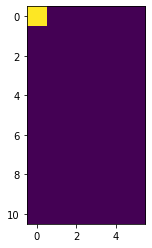

In [27]:
plt.imshow(torch.exp(Mbar_infoNCE))

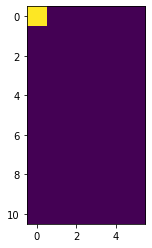

In [28]:
plt.imshow(torch.exp(M_infoNCE))

In [29]:
# Compare Mbar with xy
F_infoNCE = torch.exp(Mbar_infoNCE)
F_infoNCE_normalized = F_infoNCE/torch.sum(F_infoNCE)
log_F_infoNCE_normalized = torch.log(F_infoNCE_normalized)

F.kl_div(log_F_infoNCE_normalized, torch.from_numpy(xy))

tensor(0.0761, dtype=torch.float64)

In [14]:
def run_expr_all_samples(n_batch):
    '''
    model pxy directly
    '''
    torch.manual_seed(42)
    
    M = torch.randn((x.shape[0],y.shape[0]), requires_grad = True)
    print(M[0, :5])
    
    optimizer = torch.optim.SGD([M], 1, 0.99)
    Mbar = M.data
    
    history = {'loss':[]}
    
    samples_indices = list(itertools.product(*[range(x.shape[0]), range(y.shape[0])]))
    samples_all = list(itertools.product(*[samples_indices for _ in range(n_batch)]))
    itr_ids = list(range(len(samples_all)))
    import pdb; pdb.set_trace
    random.shuffle(itr_ids)
    
    for iteration in tqdm(range(1,len(samples_all)+1)):

        samples = samples_all[itr_ids[iteration]]

        optimizer.zero_grad()

        F = torch.exp(M)

        loss = 0
        for i in range(n_batch):
            lossi = F[samples[i][0],samples[i][1]]/torch.sum(F[:,:])
            loss = loss + torch.log(lossi)
        loss = -1*loss/n_batch
        loss.backward()
        optimizer.step()
        history['loss'].append(loss.item())
        Mbar = (1-1/iteration)*Mbar + (1/iteration)*M.data

        if iteration % 500 == 0:
            print(torch.var(M))
            plt.imshow(Mbar.detach().cpu().numpy())
            plt.savefig(f"dicerolls_training_results/Mbar_joint_{n_batch}_{iteration}.png")

    np.save(f'dicerolls_training_results/Mbar_joint_{n_batch}_{iteration}.npy', Mbar.detach().cpu().numpy())
    np.save(f'dicerolls_training_results/M_joint_{n_batch}_{iteration}.npy', M.detach().cpu().numpy())
    np.save(f'dicerolls_training_results/training_loss_joint_{n_batch}_{iteration}.npy', np.array(history['loss']))
    return M, Mbar, history

tensor([ 1.9269,  1.4873,  0.9007, -2.1055], grad_fn=<SliceBackward>)


  0%|          | 367/17210368 [00:00<6:21:06, 752.63it/s]

tensor(54.0543, grad_fn=<VarBackward0>)


  0%|          | 808/17210368 [00:00<7:01:19, 680.76it/s]/home/user/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/user/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/user/.local/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
  0%|          | 1331/17210368 [00:00<4:22:32, 1092.49it/s]

tensor(nan, grad_fn=<VarBackward0>)
tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 2395/17210368 [00:01<2:26:45, 1954.24it/s]

tensor(nan, grad_fn=<VarBackward0>)
tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 3210/17210368 [00:01<2:11:32, 2180.18it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 3802/17210368 [00:01<2:01:56, 2351.69it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 4358/17210368 [00:02<2:03:22, 2324.42it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 4906/17210368 [00:02<2:01:43, 2355.93it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 5158/17210368 [00:02<2:12:06, 2170.48it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 5703/17210368 [00:02<2:12:20, 2166.71it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 6307/17210368 [00:03<2:04:24, 2304.64it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 6849/17210368 [00:03<2:04:59, 2294.07it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 7393/17210368 [00:03<2:06:01, 2275.06it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 7638/17210368 [00:03<2:20:46, 2036.73it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 8192/17210368 [00:03<2:22:21, 2013.89it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 8726/17210368 [00:04<2:26:48, 1952.92it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 9279/17210368 [00:04<2:19:31, 2054.68it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 9807/17210368 [00:04<2:18:34, 2068.69it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 10339/17210368 [00:05<2:18:21, 2071.83it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 10573/17210368 [00:05<2:37:10, 1823.77it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 10867/17210368 [00:05<2:19:21, 2057.01it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 11609/17210368 [00:06<3:58:42, 1200.85it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 12137/17210368 [00:06<3:21:14, 1424.38it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 12671/17210368 [00:06<3:03:07, 1565.24it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 13209/17210368 [00:06<2:54:14, 1644.93it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 13500/17210368 [00:07<3:01:25, 1579.82it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 14027/17210368 [00:07<2:58:29, 1605.70it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 14563/17210368 [00:07<2:56:50, 1620.60it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 14867/17210368 [00:07<2:32:07, 1884.00it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 15614/17210368 [00:08<4:40:03, 1023.28it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 16143/17210368 [00:09<3:51:09, 1239.73it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 16669/17210368 [00:09<3:27:48, 1379.00it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 17199/17210368 [00:09<3:16:40, 1456.98it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 17500/17210368 [00:09<3:22:08, 1417.60it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 18012/17210368 [00:10<3:20:35, 1428.49it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 18539/17210368 [00:10<3:18:01, 1446.88it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 19057/17210368 [00:10<3:20:05, 1431.96it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 19565/17210368 [00:11<3:24:48, 1398.97it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 20061/17210368 [00:11<3:29:16, 1369.05it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 20571/17210368 [00:11<3:31:15, 1356.13it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 21072/17210368 [00:12<3:41:17, 1294.62it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 21557/17210368 [00:12<3:44:52, 1273.95it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 22050/17210368 [00:12<3:46:40, 1263.80it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 22548/17210368 [00:13<3:48:02, 1256.19it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 23036/17210368 [00:13<3:49:40, 1247.22it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 23543/17210368 [00:13<3:49:02, 1250.64it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 24057/17210368 [00:14<3:48:51, 1251.56it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 24575/17210368 [00:14<3:48:33, 1253.18it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 24879/17210368 [00:14<3:08:17, 1521.16it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 25387/17210368 [00:14<3:09:45, 1509.43it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 25909/17210368 [00:15<3:11:12, 1497.88it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 26432/17210368 [00:15<3:11:28, 1495.71it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 26955/17210368 [00:15<3:11:42, 1493.82it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 27480/17210368 [00:16<3:13:18, 1481.50it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 28000/17210368 [00:16<4:08:24, 1152.87it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 28501/17210368 [00:17<4:13:51, 1128.08it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 29015/17210368 [00:17<4:14:07, 1126.82it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 29326/17210368 [00:17<3:25:34, 1392.89it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 29840/17210368 [00:18<3:25:44, 1391.77it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 30359/17210368 [00:18<3:26:35, 1385.97it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 30879/17210368 [00:18<3:27:03, 1382.83it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 31399/17210368 [00:19<3:28:19, 1374.42it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 31921/17210368 [00:19<3:29:54, 1363.94it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 32440/17210368 [00:19<3:31:15, 1355.19it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 32963/17210368 [00:20<3:32:50, 1345.11it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 33484/17210368 [00:20<3:35:46, 1326.77it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 33997/17210368 [00:21<3:38:24, 1310.76it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 34206/17210368 [00:21<4:35:39, 1038.49it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 34807/17210368 [00:21<3:49:57, 1244.83it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 35302/17210368 [00:22<3:54:49, 1218.98it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 35806/17210368 [00:22<3:54:35, 1220.21it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 36316/17210368 [00:23<3:54:02, 1222.97it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 36815/17210368 [00:23<3:55:31, 1215.25it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 37327/17210368 [00:23<3:55:48, 1213.75it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 37843/17210368 [00:24<3:56:03, 1212.41it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 38355/17210368 [00:24<3:56:44, 1208.93it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 38871/17210368 [00:25<3:58:13, 1201.31it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 39383/17210368 [00:25<4:00:58, 1187.57it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 39881/17210368 [00:25<4:04:44, 1169.27it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 40385/17210368 [00:26<4:10:28, 1142.49it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 40893/17210368 [00:26<4:11:14, 1138.98it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 41401/17210368 [00:27<4:12:16, 1134.31it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 41912/17210368 [00:27<4:11:56, 1135.74it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 42424/17210368 [00:28<4:12:04, 1135.12it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 42937/17210368 [00:28<4:12:48, 1131.78it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 43448/17210368 [00:29<4:14:35, 1123.84it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 43957/17210368 [00:29<4:16:12, 1116.66it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 44461/17210368 [00:29<4:17:56, 1109.13it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 44970/17210368 [00:30<4:21:00, 1096.07it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 45476/17210368 [00:30<4:22:42, 1088.97it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 45984/17210368 [00:31<4:25:10, 1078.83it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 46491/17210368 [00:31<4:26:56, 1071.62it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 46693/17210368 [00:32<5:43:34, 832.61it/s] 

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 47306/17210368 [00:32<4:36:10, 1035.73it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 47805/17210368 [00:33<4:38:48, 1025.95it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 48309/17210368 [00:33<4:40:15, 1020.63it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 48816/17210368 [00:34<4:40:45, 1018.76it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 49325/17210368 [00:34<4:42:34, 1012.21it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 49832/17210368 [00:35<4:42:32, 1012.26it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 50333/17210368 [00:35<4:43:54, 1007.38it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 50838/17210368 [00:36<4:48:42, 990.60it/s] 

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 51348/17210368 [00:36<4:50:35, 984.12it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 51845/17210368 [00:37<4:53:33, 974.19it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 52340/17210368 [00:37<4:57:26, 961.44it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 52831/17210368 [00:38<5:03:20, 942.71it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 53332/17210368 [00:38<5:05:47, 935.14it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 53819/17210368 [00:39<5:07:15, 930.62it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 54316/17210368 [00:39<5:08:57, 925.45it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 54804/17210368 [00:40<5:09:54, 922.61it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 55293/17210368 [00:40<5:12:12, 915.81it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 55793/17210368 [00:41<5:07:58, 928.37it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 56301/17210368 [00:41<5:06:01, 934.22it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 56788/17210368 [00:42<5:11:41, 917.21it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 57272/17210368 [00:42<5:08:54, 925.48it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 57778/17210368 [00:43<5:02:54, 943.75it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 58306/17210368 [00:44<4:57:22, 961.32it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 58804/17210368 [00:44<5:10:36, 920.32it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 59298/17210368 [00:45<5:18:01, 898.81it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 59802/17210368 [00:45<5:19:15, 895.33it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 60297/17210368 [00:46<5:22:27, 886.42it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 60806/17210368 [00:46<5:24:36, 880.54it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 61305/17210368 [00:47<5:28:58, 868.80it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 61813/17210368 [00:47<5:30:41, 864.27it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 62317/17210368 [00:48<5:29:52, 866.39it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 62821/17210368 [00:49<5:30:23, 865.01it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 63323/17210368 [00:49<5:30:43, 864.09it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 63824/17210368 [00:50<5:34:21, 854.68it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 64324/17210368 [00:50<5:36:06, 850.24it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 64825/17210368 [00:51<5:38:32, 844.10it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 65330/17210368 [00:51<5:40:27, 839.30it/s]

tensor(nan, grad_fn=<VarBackward0>)


  0%|          | 65499/17210368 [00:52<3:48:11, 1252.24it/s]


KeyboardInterrupt: 

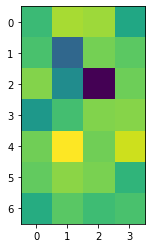

In [15]:
# model pxy directly
M, Mbar, history = run_expr_all_samples(n_batch=5)

In [12]:
28**5

17210368